# Example of Jaraguari RADAR file reading #

- Rain rate (mm/h) at CAPPI 3 km (Process reference: https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import geopy
from geopy import distance

In [ ]:
#file properties
ds=xr.open_dataset('jaraguari_201801010130.nc')
ds

<xarray.Dataset> Size: 15MB
Dimensions:        (x: 500, y: 500)
Coordinates:
  * x              (x) float64 4kB -56.84 -56.83 -56.82 ... -52.07 -52.06 -52.05
  * y              (y) float64 4kB -22.51 -22.5 -22.49 ... -18.04 -18.03 -18.02
Data variables: (12/15)
    cappi_3km_CZ   (y, x) float32 1MB ...
    ppi_0.5deg_CZ  (y, x) float32 1MB ...
    ppi_1.5deg_CZ  (y, x) float32 1MB ...
    ppi_2.5deg_CZ  (y, x) float32 1MB ...
    ppi_0.5deg_DR  (y, x) float32 1MB ...
    ppi_1.5deg_DR  (y, x) float32 1MB ...
    ...             ...
    ppi_2.5deg_KD  (y, x) float32 1MB ...
    cappi_3km_DR   (y, x) float32 1MB ...
    cappi_3km_KD   (y, x) float32 1MB ...
    r_kdp          (y, x) float32 1MB ...
    r_zr           (y, x) float32 1MB ...
    rain           (y, x) float32 1MB ...
Attributes:
    Conventions:  CF-1.7
    GMT_version:  6.0.0 [64-bit]
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...
    title:        Radar jaraguari
    scan:         20180101_0130

In [41]:
#load variables
Longitude = ds['x'].data
Latitude = ds['y'].data
RR = ds['rain'].data


# Conversion to Rain rate #

First, Z_H, initially measured in logarithmic units (dBZ), is converted to mm⁶ m⁻³.

\begin{equation}
\text{RR}_{\text{RADAR}} = 3 \times 10^{-4} \times \left(10^{Z_H / 10}\right)^{0.69}
\end{equation}

Subsequently, for different rainfall intensities, RR$_{RADAR}$ is refined using empirical relationships involving Z$_{DR}$ and K$_{DP}$:

For light rain (RR$_{RADAR} < 6$ mm h$^{-1}$):

\begin{equation}
\text{RR}_{\text{RADAR}} = \frac{\text{RR}_{\text{RADAR}}}{0.4 + 5 \times \left| \text{Z}_{\text{dr}} - 1 \right|^{1.3}}
\end{equation}

For moderate rain ($6 <$ RR$_{RADAR} < 50$ mm h$^{-1}$):

\begin{equation}
    RR_{\text{RADAR}} = \frac{44 \times |K_{DP}|^{0.822}}{0.4 + 3.5 \times |Z_{DR} - 1|^{1.7}}
\end{equation}

For heavy rain (RR$_{RADAR} > 50$ mm h$^{-1}$):

\begin{equation}
    RR_{\text{RADAR}} = 44 \times |K_{DP}|^{0.822}
\end{equation}

Finally, to eliminate echoes of non-meteorological origin, such as ground clutter, anomalous propagation, biological scatterers, and chaff, the rain rate is set to zero wherever $\rho$hv is less than 0.85.

In [30]:
# variables fom S-band dual polarization RADAT at cappi 3 km
kdp=ds['cappi_3km_KD'].data
zdr=ds['cappi_3km_DR'].data
refl=ds['cappi_3km_CZ'].data

#rain rate with kdp
rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)

#rain rate with z-r through NEXRAD empirical equations
refl_linear = np.ma.power(10.0, refl/10.0)
r_zr = np.ma.power(refl_linear/300., 1/1.4)

#copy r_zr as output array
rain = r_zr.copy()
# verify thresholds to Z-ZDR-KDP use
idx = np.where(r_zr <= 6)
rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))

idx = np.where(r_zr > 6)
rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))

idx = np.where(r_zr > 50)
rain[idx] = rkdp[idx]



In [19]:
#plotting functions

def scam_circle(lon_r, lat_r,dis):
    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((361))
    lats = np.zeros((361))
    for az in range(361):
        destination = distance.distance(kilometers=dis).destination(origin, az)
        lat2, lon2 = destination.latitude, destination.longitude
        lons[az] = lon2
        lats[az] = lat2

    return lons,lats

radar_central_lon=-54.44;radar_central_lat=-20.26
radar_scam=scam_circle(radar_central_lon,radar_central_lat,250)

def cartopy_settings(ax):
    ax.set_extent([-58.5, -50.5, -24.5, -17], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS,linewidth=3)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.STATES)
    #insert lat and lon lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=.2, color='gray', alpha=0.5, linestyle='--')
    gl.left_labels = True
    gl.bottom_labels = True
    gl.right_labels = False
    gl.top_labels = False


Text(0.5, 1.0, 'Raw file')

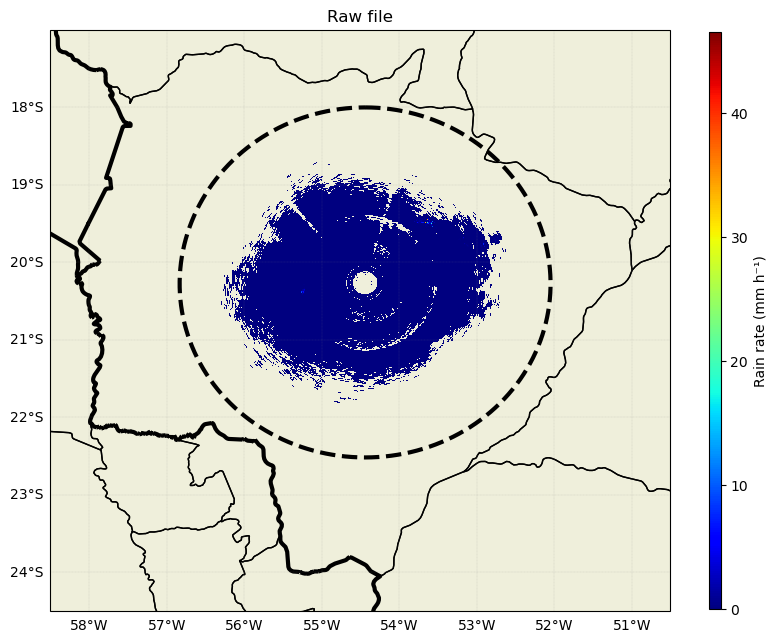

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cartopy_settings(ax)
ax.plot(radar_scam[0],radar_scam[1],'--',c='k',linewidth=3,transform=ccrs.PlateCarree())

cf=ax.pcolormesh(Longitude,Latitude,RR,transform=ccrs.PlateCarree(),cmap='jet')
#colorbar for cf
plt.colorbar(cf, aspect=50,shrink=.75,label='Rain rate (mm h⁻¹)')
ax.set_title('Raw file')

Text(0.5, 1.0, 'Processed file')

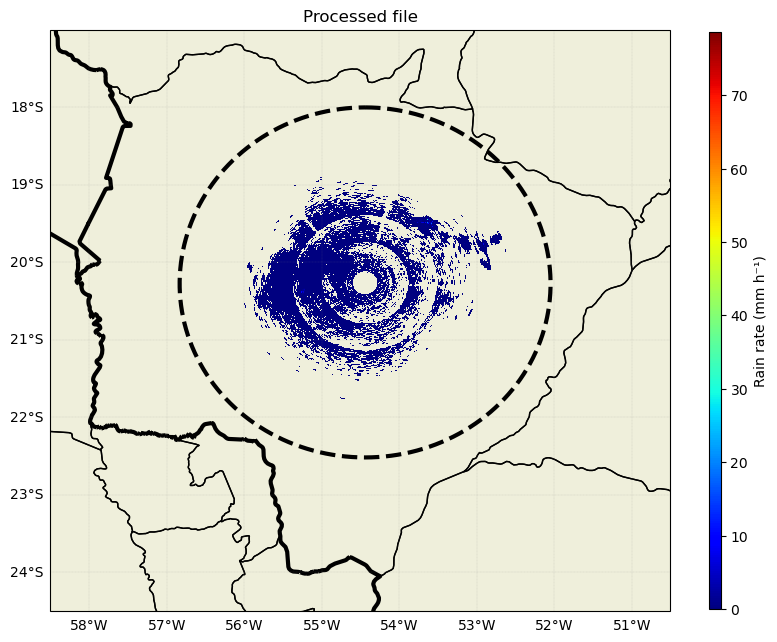

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cartopy_settings(ax)
ax.plot(radar_scam[0],radar_scam[1],'--',c='k',linewidth=3,transform=ccrs.PlateCarree())

cf=ax.pcolormesh(Longitude,Latitude,rain,transform=ccrs.PlateCarree(),cmap='jet')
#colorbar for cf
plt.colorbar(cf, aspect=50,shrink=.75,label='Rain rate (mm h⁻¹)')
ax.set_title('Processed file')

# verifying the threshold of 0.1 mm/h

In [52]:
RR_01=RR.copy()
RR_01[RR<.1]=np.nan

rain_01=rain.copy()
rain_01[rain<.1]=np.nan

Text(0.5, 1.0, 'Raw file')

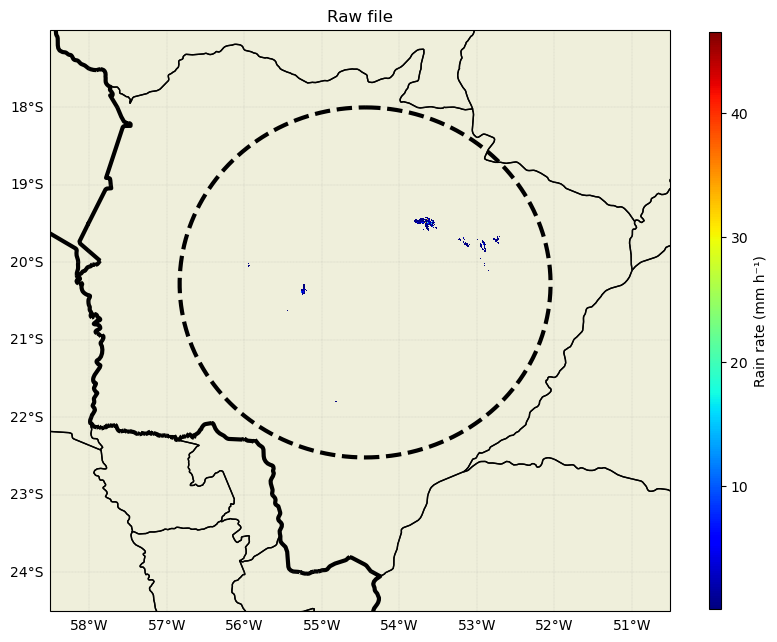

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cartopy_settings(ax)
ax.plot(radar_scam[0],radar_scam[1],'--',c='k',linewidth=3,transform=ccrs.PlateCarree())

cf=ax.pcolormesh(Longitude,Latitude,RR_01,transform=ccrs.PlateCarree(),cmap='jet')
#colorbar for cf
plt.colorbar(cf, aspect=50,shrink=.75,label='Rain rate (mm h⁻¹)')
ax.set_title('Raw file')

Text(0.5, 1.0, 'Processed file')

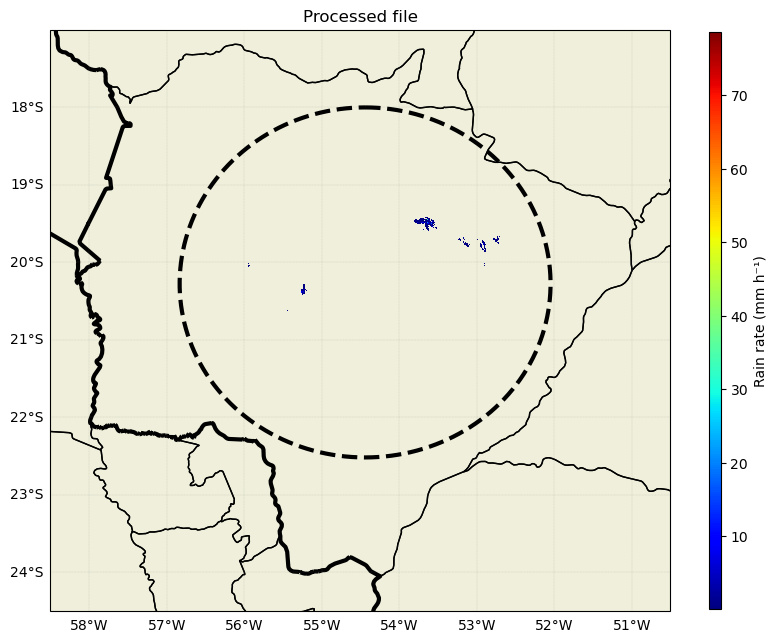

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cartopy_settings(ax)
ax.plot(radar_scam[0],radar_scam[1],'--',c='k',linewidth=3,transform=ccrs.PlateCarree())

cf=ax.pcolormesh(Longitude,Latitude,rain_01,transform=ccrs.PlateCarree(),cmap='jet')
#colorbar for cf
plt.colorbar(cf, aspect=50,shrink=.75,label='Rain rate (mm h⁻¹)')
ax.set_title('Processed file')